# Exercise Session 7 – Multi Regional Input Output (MRIO) Analysis
### ENV–501 Material and Energy Flow Analysis

November 3, 2022

Exercises developed for Jupyter Notebook by Matteo Barsanti



### Ex. 1 - Economy wide MFA with EXIOBASE 3 and pymrio 

EXIOBASE is a global, detailed Multi-Regional Environmentally Extended Supply-Use Table (MR-SUT) and Input-Output Table (MR-IOT). It was developed by harmonizing and detailing supply-use tables for a large number of countries, estimating emissions and resource extractions by industry. Subsequently the country supply-use tables were linked via trade creating an MR-SUT and producing a MR-IOTs from this. The MR-IOT that can be used for the analysis of the environmental impacts associated with the final consumption of product groups.

1. Compute the EW-MFA for Switzerland for the year 2019 based on the sum of Domestic extraction used and unused. 
2. Compare your results with the EW-MFA from [OFS](https://www.bfs.admin.ch/bfs/fr/home/statistiques/espace-environnement/comptabilite-environnementale/flux-matieres.html) (see Tab. 1). How would you explain the differences?

<br/>

|Flux de matières en Suisse                            | 2019   |
| ---                                                  | :-:    |  
|Extraction intérieure utilisée (DE), mio. tonnne      | 60.2   |	 
|Extraction intérieure non-utilisée (UDE), mio. tonnes | 62.8   |   
|Importations, mio. tonnes	                           | 52.5   | 
|Exportations, mio. tonnes                             | 17.5   |	
|Emissions dans la nature (DPO), mio. tonnes           | 55.5   |	

<br/>

<center> Table 1: Flux de matières en Suisse. </center>

<ins>Requirements:</ins>
* Download the dataset EXIOBASE 3 for 2019 https://zenodo.org/record/4588235#.YYKIOm3MKUk
* Install the Python library pymrio https://pypi.org/project/pymrio/

<ins>Acronyms:</ins>
* IxI: industry by industry 
* PxP: product by product 

### Economy-wide MFA 

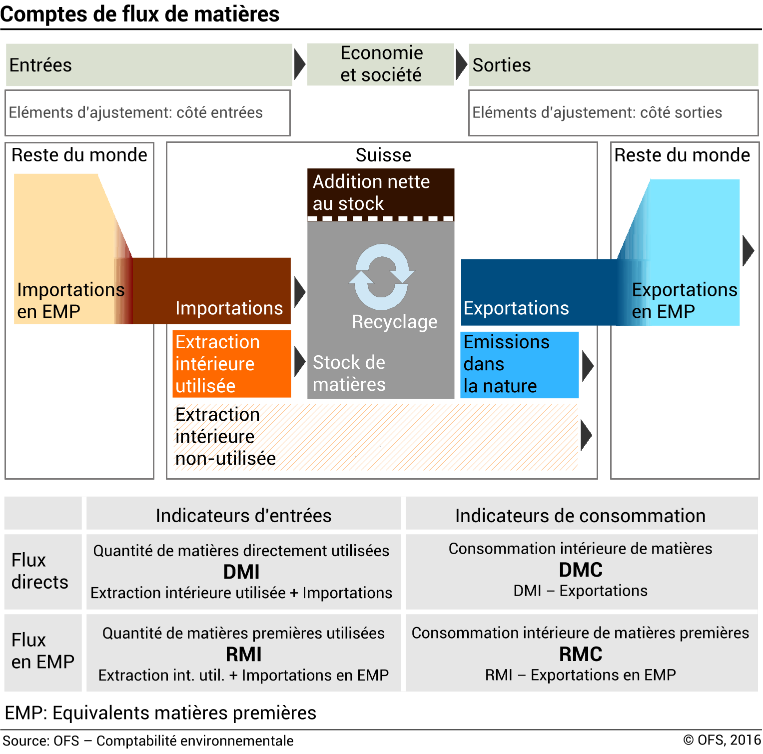

In [1]:
from IPython.display import Image
Image(filename='EWMFA_scheme.PNG') 

### MRIOA

Based on the linear economy assumption of the IO model and the classic Leontief demand-style modeling, total industry output $X$ can be calculated for any arbitrary vector of final demand $Y$ by multiplying with the total requirement matrix (Leontief matrix) $L$.

$X = (1-A)^{-1}Y = LY$

Hence, the total material requirements for any given final demand vector $Y$ are given by

$b = BX = BLY$ 

where $B$ is the diagonalized factor production - (pymrio refers to it with $F$)


### Exercise procedure

In [2]:
# -- Import the required libraries 

import pymrio 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [3]:
# -- Check if pymrio works correctly

# load the test
test_mrio = pymrio.load_test()
# the test mrio consists of six regions and eight sectors:
print(test_mrio.get_sectors())
print(test_mrio.get_regions())

Index(['food', 'mining', 'manufactoring', 'electricity', 'construction',
       'trade', 'transport', 'other'],
      dtype='object', name='sector')
Index(['reg1', 'reg2', 'reg3', 'reg4', 'reg5', 'reg6'], dtype='object', name='region')


In [4]:
# -- Import the data (it takes 2/3 minutes)

exio3 = pymrio.parse_exiobase3(path=r'C:\Users\barsanti.INTRANET\Desktop\Courses\MFA\W8_MRIO\IOT_2019_ixi.zip')

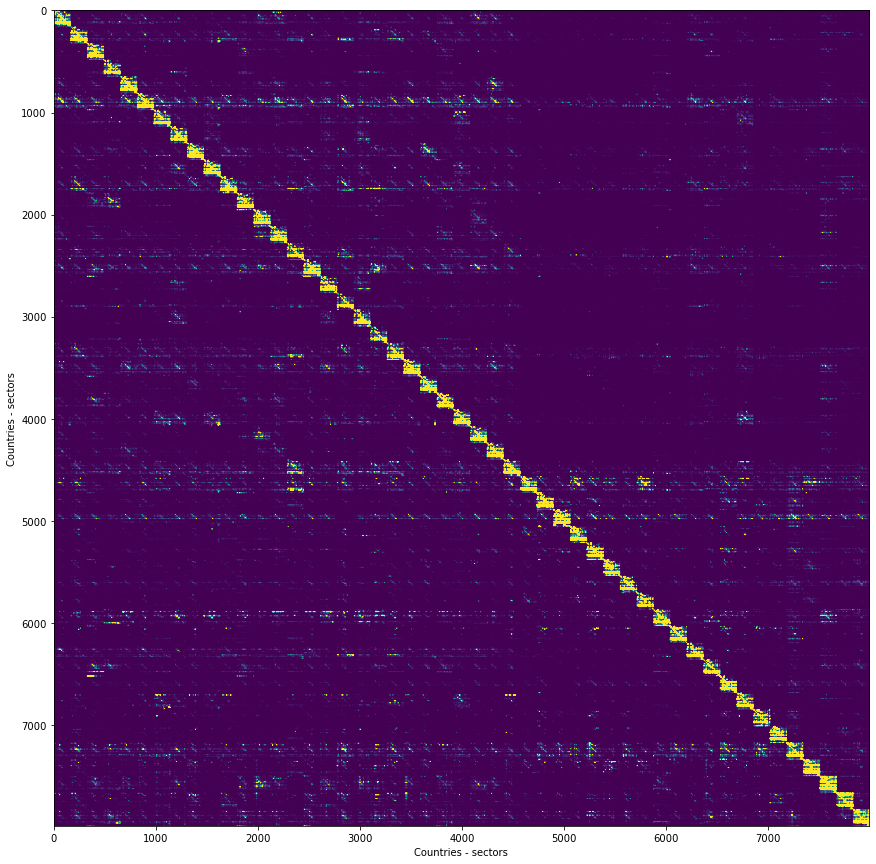

In [7]:
# -- Direct requirement matrix or matrix of coefficients - A

fig = plt.figure(figsize=(15,15))
plt.imshow(exio3.A, vmax=1E-3)
plt.xlabel('Countries - sectors')
plt.ylabel('Countries - sectors')
plt.show()

In [ ]:
# -- Access EXIOBASE metadata

# exio3.meta
# to check for sectors, regions and extensions:
# exio3.get_sectors()
# list of all regions available
# exio3.get_regions()

#### 1. Select your stressor and calculate the vector of resources/impact

In [6]:
# -- Show the available the satellite accounts/ stressors
groups = exio3.satellite.get_index()
for f in groups:
    print(f)

Taxes less subsidies on products purchased: Total
Other net taxes on production
Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled
Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled
Compensation of employees; wages, salaries, & employers' social contributions: High-skilled
Operating surplus: Consumption of fixed capital
Operating surplus: Rents on land
Operating surplus: Royalties on resources
Operating surplus: Remaining net operating surplus
Employment: Low-skilled male
Employment: Low-skilled female
Employment: Medium-skilled male
Employment: Medium-skilled female
Employment: High-skilled male
Employment: High-skilled female
Employment hours: Low-skilled male
Employment hours: Low-skilled female
Employment hours: Medium-skilled male
Employment hours: Medium-skilled female
Employment hours: High-skilled male
Employment hours: High-skilled female
Employment: Vulnerable employment
Employment hours: Vulne

To aggregate these with the Pandas groupby function, we need to specify the groups which should be grouped by Pandas. Pymrio contains a helper function which builds such a matching dictionary. The matching can also include regular expressions to simplify the build.

In [8]:
# -- Grouping the satellite accounts/ stressors - B

groups = exio3.satellite.get_index(as_dict=True, grouping_pattern = {'.': 'Other',
                                                                     'Domestic Extraction Used*.': 'Material Used',
                                                                     'Unused*.': 'Material Unused'})
groups

{'Taxes less subsidies on products purchased: Total': 'Other',
 'Other net taxes on production': 'Other',
 "Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled": 'Other',
 "Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled": 'Other',
 "Compensation of employees; wages, salaries, & employers' social contributions: High-skilled": 'Other',
 'Operating surplus: Consumption of fixed capital': 'Other',
 'Operating surplus: Rents on land': 'Other',
 'Operating surplus: Royalties on resources': 'Other',
 'Operating surplus: Remaining net operating surplus': 'Other',
 'Employment: Low-skilled male': 'Other',
 'Employment: Low-skilled female': 'Other',
 'Employment: Medium-skilled male': 'Other',
 'Employment: Medium-skilled female': 'Other',
 'Employment: High-skilled male': 'Other',
 'Employment: High-skilled female': 'Other',
 'Employment hours: Low-skilled male': 'Other',
 'Employment hours: Low-skilled female

In [9]:
# -- Aggreagated the stressor based on the selected grouping patterns

# copy the stressors
exio3.satellite_agg = exio3.satellite.copy(new_name='Aggregated matrial accounts')

# aggregate the stressors
for df_name, df in zip(exio3.satellite_agg.get_DataFrame(data=False, with_unit=True, with_population=False),
                       exio3.satellite_agg.get_DataFrame(data=True, with_unit=True, with_population=False)):
    if df_name == 'unit':
        exio3.satellite_agg.__dict__[df_name] = df.groupby(groups).apply(lambda x: ' & '.join(x.unit.unique()))
    else:
        exio3.satellite_agg.__dict__[df_name] = df.groupby(groups).sum()
        
# show the aggregated stressors
exio3.satellite_agg.F

region                                 AT                       \
sector          Cultivation of paddy rice Cultivation of wheat   
Material Unused                         0         4.666162e+02   
Material Used                           0         1.555895e+03   
Other                                   0         3.062581e+08   

region                                            \
sector          Cultivation of cereal grains nec   
Material Unused                     1.453725e+03   
Material Used                       3.236979e+03   
Other                               2.963542e+08   

region                                                  \
sector          Cultivation of vegetables, fruit, nuts   
Material Unused                           2.728060e+03   
Material Used                             2.486857e+03   
Other                                     1.187535e+08   

region                                    \
sector          Cultivation of oil seeds   
Material Unused             3.764610e+02   
Material Used               4.574374e+02   
Other                       6.445019e+07   

region                                                 \
sector          Cultivation of sugar cane, sugar beet   
Material Unused                          1.671331e+03   
Material Used                            3.342662e+03   
Other                                    1.887009e+07   

region                                                                      \
sector          Cultivation of plant-based fibers Cultivation of crops nec   
Material Unused                          0.611181             1.578241e+01   
Material Used                            3.055905             7.952609e+01   
Other                                83810.687471             2.922371e+06   

region                                        ...                       WM  \
sector          Cattle farming  Pigs farming  ... Landfill of waste: Paper   
Material Unused   1.790683e+03  6.494054e+01  ...             4.069086e+02   
Material Used     1.184321e+04  2.054320e+02  ...             5.239196e+02   
Other             3.140669e+08  8.876205e+07  ...             1.798950e+09   

region                                      \
sector          Landfill of waste: Plastic   
Material Unused               5.101912e+01   
Material Used                 7.888026e+01   
Other                         9.597462e+07   

region                                                    \
sector          Landfill of waste: Inert/metal/hazardous   
Material Unused                             1.265770e+02   
Material Used                               1.523015e+02   
Other                                       4.858009e+07   

region                                                               \
sector          Landfill of waste: Textiles Landfill of waste: Wood   
Material Unused                6.935581e+01            9.661774e+01   
Material Used                  9.744218e+01            1.437046e+02   
Other                          2.849374e+08            1.038386e+08   

region                                                             \
sector          Activities of membership organisation n.e.c. (91)   
Material Unused                                      9.534208e-01   
Material Used                                        6.357661e+00   
Other                                                2.660589e+08   

region                                                               \
sector          Recreational, cultural and sporting activities (92)   
Material Unused                                       4.109314e+01    
Material Used                                         5.954909e+01    
Other                                                 4.738760e+08    

region                                         \
sector          Other service activities (93)   
Material Unused                  1.851446e-04   
Material Used                    6.055194e-04   
Other                            3.407220e

In [10]:
# -- Show the aggregated stressor unites

exio3.satellite_agg.unit

Material Unused                                                   kt
Material Used                                                     kt
Other              M.EUR & 1000 p & M.hr & kg & kg CO2-eq & km2 &...
dtype: object

In [11]:
# -- Diagonalized the stressors

res_diag   = exio3.satellite_agg.diag_stressor(('Material Unused'), name = 'res_diag')

# show diagonalized stressor
res_diag.F.head(10)

region                                                               AT  \
sector                                        Cultivation of paddy rice   
region sector                                                             
AT     Cultivation of paddy rice                                    0.0   
       Cultivation of wheat                                         0.0   
       Cultivation of cereal grains nec                             0.0   
       Cultivation of vegetables, fruit, nuts                       0.0   
       Cultivation of oil seeds                                     0.0   
       Cultivation of sugar cane, sugar beet                        0.0   
       Cultivation of plant-based fibers                            0.0   
       Cultivation of crops nec                                     0.0   
       Cattle farming                                               0.0   
       Pigs farming                                                 0.0   

region                                                              \
sector                                        Cultivation of wheat   
region sector                                                        
AT     Cultivation of paddy rice                          0.000000   
       Cultivation of wheat                             466.616174   
       Cultivation of cereal grains nec                   0.000000   
       Cultivation of vegetables, fruit, nuts             0.000000   
       Cultivation of oil seeds                           0.000000   
       Cultivation of sugar cane, sugar beet              0.000000   
       Cultivation of plant-based fibers                  0.000000   
       Cultivation of crops nec                           0.000000   
       Cattle farming                                     0.000000   
       Pigs farming                                       0.000000   

region                                                                          \
sector                                        Cultivation of cereal grains nec   
region sector                                                                    
AT     Cultivation of paddy rice                                      0.000000   
       Cultivation of wheat                                           0.000000   
       Cultivation of cereal grains nec                            1453.725335   
       Cultivation of vegetables, fruit, nuts                         0.000000   
       Cultivation of oil seeds                                       0.000000   
       Cultivation of sugar cane, sugar beet                          0.000000   
       Cultivation of plant-based fibers                              0.000000   
       Cultivation of crops nec                                       0.000000   
       Cattle farming                                                 0.000000   
       Pigs farming                                                   0.000000   

region                                                                                \
sector                                        Cultivation of vegetables, fruit, nuts   
region sector                                                                          
AT     Cultivation of paddy rice                                            0.000000   
       Cultivation of wheat                                                 0.000000   
       Cultivation of cereal grains nec                                     0.000000   
       Cultivation of vegetables, fruit, nuts                            2728.060397   
       Cultivation of oil seeds                                             0.000000   
       Cultivation of sugar cane, sugar beet                                0.000000   
       Cultivation of plant-based fibers                                    0.000000   
       Cultivation of crops nec                                             0.000000   
       Cattle farming                                                       0.

In [12]:
# -- Perform all the calculation (it takes around 2/3 minutes)

# set the stressor diagonal
exio3.res_diag = res_diag
# calculate
exio3.calc_all()

In [13]:
## -- Save the results

name = 'CH_unused'
exio3.res_diag.D_cba.to_csv(name + '_b.csv') 

#### 2. Compare the EXIOBASE 3 results with FSO

In [14]:
# -- Load the ew mfa statistics once saved in csv files

unused_b = pd.read_csv('CH_unused_b.csv')
used_b = pd.read_csv('CH_used_b.csv')

C:\Users\barsanti.INTRANET\Anaconda3\envs\mfa\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,

In [15]:
# -- Results

results = pd.DataFrame([[pd.to_numeric(used_b.CH.loc[2:]).sum(), 60.2 ],
                        [pd.to_numeric(unused_b.CH.loc[2:]).sum(), 62.8]],
                       index=['Used DE','Unused DE'],
                       columns=['EXIOBASE 3', 'OFS'])
results

,EXIOBASE 3,OFS
Used DE,57.083723,60.2
Unused DE,41.507166,62.8
